In [1]:
import numpy as np
import pandas as pd

import statsmodels
from statsmodels.tsa.stattools import coint
from scipy import stats
# just set the seed for the random number generator
np.random.seed(107)

import matplotlib.pyplot as plt

from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from datetime import datetime

### Get Data

In [2]:
startDateStr = '2010/04/20'
endDateStr = '2020/04/20'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['SPY','AAPL','ADBE','EBAY','MSFT','QCOM',
                 'HPQ','JNPR','AMD','IBM']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']

Processing data for stock: SPY
Processing data for stock: AAPL
Processing data for stock: ADBE
Processing data for stock: EBAY
Processing data for stock: MSFT
Processing data for stock: QCOM
Processing data for stock: HPQ
Processing data for stock: JNPR
Processing data for stock: AMD
Processing data for stock: IBM
20% done...
40% done...
60% done...
80% done...


### Find Cointegrated Pairs

In [3]:
def get_cointegrated_pairs(data): #takes in pds.Series
    n = data.shape[1]
    coint_mat = np.zeros((n,n))
    pvalue_mat = np.ones((n,n))
    stocks = data.keys()
    pairs = []
    
    for i in range(n):
        for j in range(i+1, n):
            s1 = data[stocks[i]]
            s2 = data[stocks[j]]
            result = coint(s1, s2)
            coint_val = result[0]
            pvalue = result[1]
            coint_mat[i, j] = coint_val
            pvalue_mat[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append([stocks[i], stocks[j]])
    return coint_mat, pvalue_mat, pairs
    

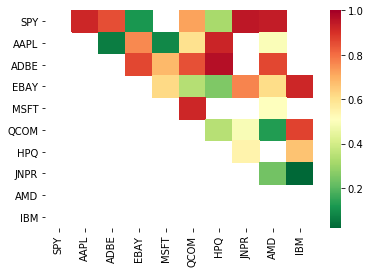

[['JNPR', 'IBM']]


In [4]:
# Heatmap to show the p-values of the cointegration test
# between each pair of stocks

scores, pvalues, pairs = get_cointegrated_pairs(data)
import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, xticklabels=instrumentIds, 
                yticklabels=instrumentIds, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.98)
                )
plt.show()
print(pairs)

#### Look at the actual series ratios

0.02122438994723762


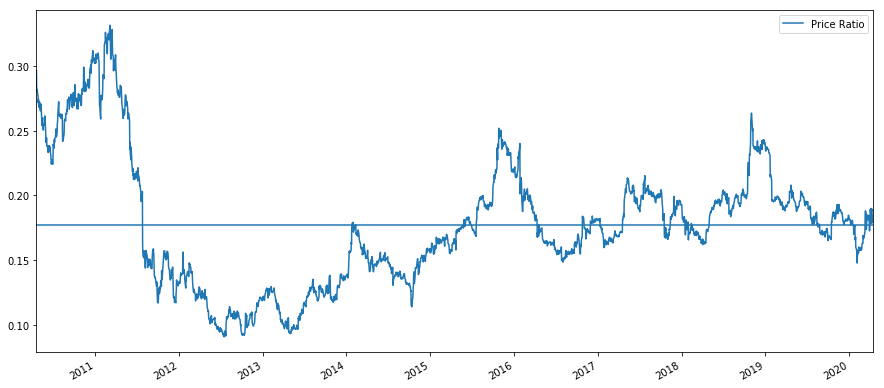

In [5]:
S1 = data[pairs[0][0]]
S2 = data[pairs[0][1]]
score, pvalue, _ = coint(S1, S2)
print(pvalue)
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean())
plt.legend(['Price Ratio'])
plt.show()

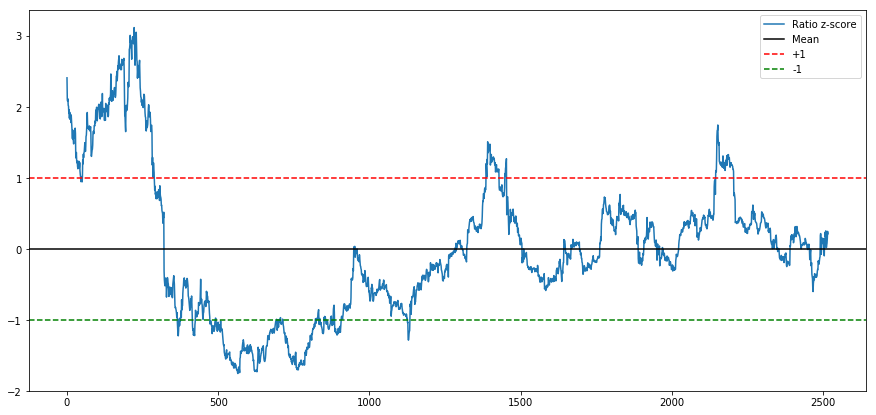

In [6]:
plt.figure(figsize=(15,7))
plt.plot(stats.zscore(ratios))
plt.axhline(stats.zscore(ratios).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

### Data Split

In [7]:
split = 0.8
ratios = data[pairs[0][0]] / data[pairs[0][1]]
print('len ratios :',len(ratios))
train = ratios[:int(len(ratios)*split)]
test = ratios[int(len(ratios)*split):]
print('len train :',len(train))
print('len test :',len(test))

len ratios : 2517
len train : 2013
len test : 504


In [9]:
# Y = train[ratios.mean()*]

### Find Features

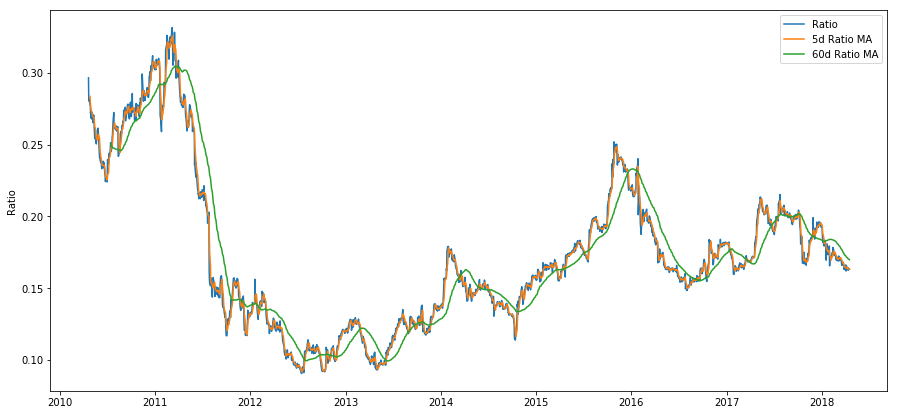

In [10]:
ratios_mavg5 = train.rolling(window=5,
                               center=False).mean()

ratios_mavg60 = train.rolling(window=60,
                               center=False).mean()

std_60 = train.rolling(window=60,
                        center=False).std()

zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)

plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

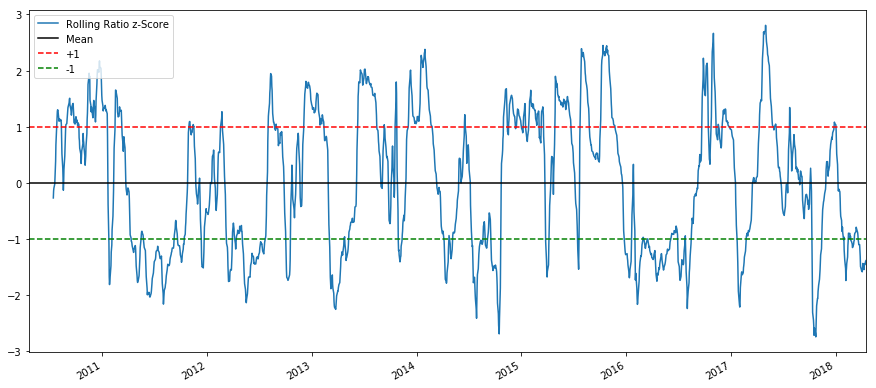

In [11]:
# Take a rolling 60 day standard deviation
std_60 = train.rolling(window=60,center=False).std()
std_60.name = 'std 60d'

# Compute the z score for each day
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
zscore_60_5.name = 'z-score'

plt.figure(figsize=(15,7))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

### Classification based on feature

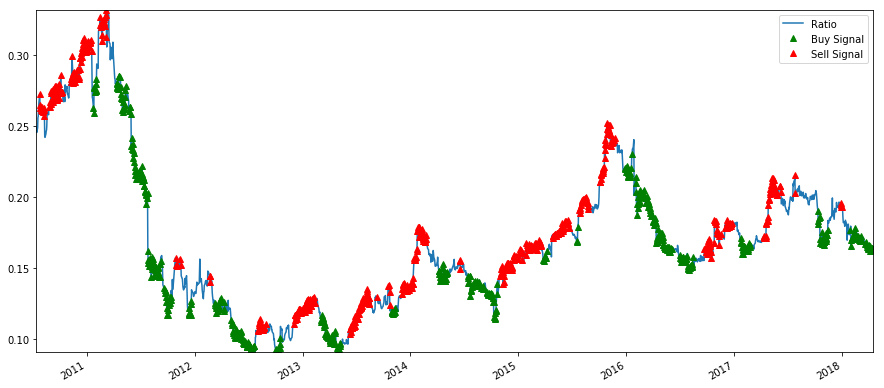

In [12]:
# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7))

train[60:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

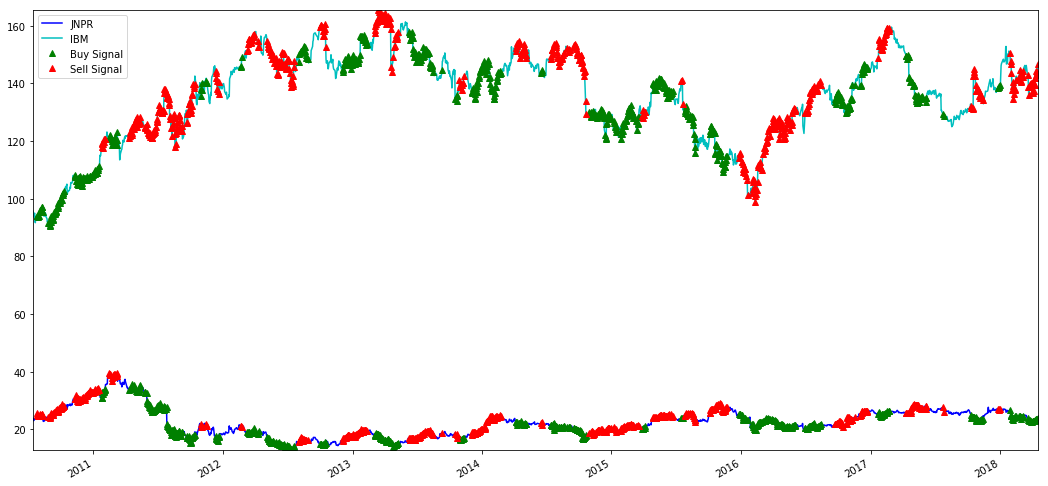

In [13]:
# Plot the prices and buy and sell signals from z score
plt.figure(figsize=(18,9))
S1 = data[pairs[0][0]].iloc[:len(train)]
S2 = data[pairs[0][1]].iloc[:len(train)]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))

plt.legend([pairs[0][0],pairs[0][1], 'Buy Signal', 'Sell Signal'])
plt.show()



In [14]:
def trade(S1, S2, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1*S1[i] + S2[i] * countS2
            countS1 = 0
            countS2 = 0
#         print('Z-score: '+ str(zscore[i]), countS1, countS2, S1[i] , S2[i])
    return money


trade(data[pairs[0][0]].iloc[:len(train)], data[pairs[0][1]].iloc[:len(train)], 5, 60)

-750.506352134709

In [15]:
trade(data[pairs[0][0]].iloc[len(train):], data[pairs[0][1]].iloc[len(train):], 5, 90)

226.9669112854331

### Hyperparameter Tuning

In [16]:
# Find the window length 0-254 
# that gives the highest returns using this strategy
length_scores = [trade(data[pairs[0][0]].iloc[:len(train)], 
                data[pairs[0][1]].iloc[:len(train)], 5, l) 
                for l in range(255)]
best_length = np.argmax(length_scores)
print ('Best window length:', best_length)

Best window length: 158


In [17]:
# Find the returns for test data
# using what we think is the best window length
length_scores2 = [trade(data['ADBE'].iloc[1762:], 
                  data['MSFT'].iloc[1762:],5, l) 
                  for l in range(255)]
print (best_length, 'day window:', length_scores2[best_length])

# Find the best window length based on this dataset, 
# and the returns using this window length
best_length2 = np.argmax(length_scores2)
print (best_length2, 'day window:', length_scores2[best_length2])

158 day window: 1739.057406790645
217 day window: 3824.282270046144


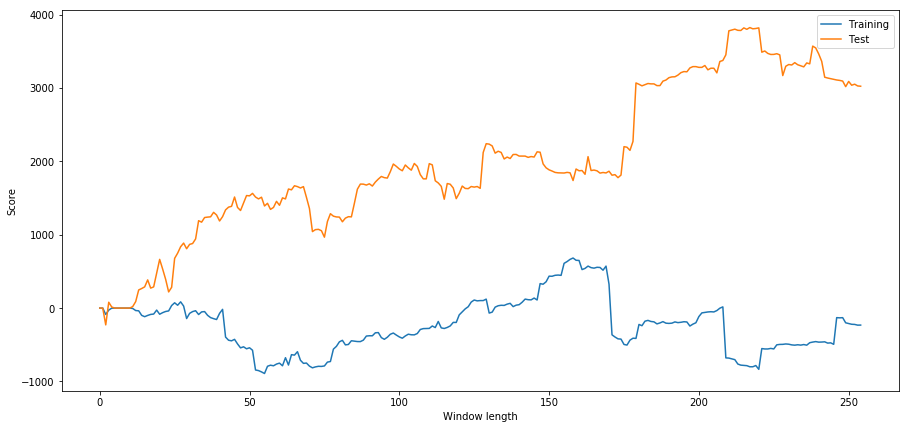

In [18]:
plt.figure(figsize=(15,7))
plt.plot(length_scores)
plt.plot(length_scores2)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['Training', 'Test'])
plt.show()

### References
https://medium.com/auquan/pairs-trading-data-science-7dbedafcfe5a